**1. Project Title & Overview**

**Description** :

**PS01: AI-Based Grey Market & Illegal Product Sales Detection**

**Objective**: This notebook demonstrates the preprocessing and exploratory data analysis (EDA) phase for detecting unauthorized "Grey Market" sales. We utilize real-world transactional data to engineer features that highlight price erosion and geographic distribution anomalies.

**Key Metrics:**

**PVI (Price Variance Index):** Deviation from the market median price.

**Revenue at Risk:** Financial impact of unauthorized discounting.



---



**2. Environment Setup & Data Ingestion**

**Description :**

**2.1. Library Imports & Data Loading**  
We begin by importing essential libraries for data manipulation (pandas, numpy) and visualization (matplotlib, seaborn). We load the UCI Online Retail II dataset retrieved in Round 1.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# Load the dataset
try:
    df = pd.read_csv("real_world_retail_data.csv")
    print(f"Dataset loaded successfully with {len(df)} records.")
except FileNotFoundError:
    print("Error: CSV file not found. Please ensure 'real_world_retail_data.csv' is in your directory.")

Dataset loaded successfully with 88827 records.


**3. Data Preprocessing**

**Description :**

**3.1. Cleaning and Noise Removal**

Real-world data is "noisy." We perform the following cleaning steps:

**Filter Returns:** Remove invoices starting with 'C' (Cancellations).

**Remove Nulls:** Drop records missing CustomerID.

**Validate Values:** Ensure Quantity and UnitPrice are greater than zero.

**Text Normalization:** Convert Description to uppercase to avoid duplicate categories.

In [3]:
# 1. Filter out cancellations
df_clean = df[~df['InvoiceDate'].str.contains('C', na=False)]

# 2. Handle missing Customer IDs
df_clean = df_clean.dropna(subset=['CustomerID'])

# 3. Validate numeric columns
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# 4. Standardize Descriptions
df_clean['Description'] = df_clean['Description'].str.upper().str.strip()

print(f"Cleaned dataset contains {len(df_clean)} valid transactions.")

Cleaned dataset contains 55255 valid transactions.


**4. Feature Engineering**

Description :

**4.1. Engineering the Price Variance Index (PVI)**
The core of Grey Market detection is identifying Price Erosion. We calculate the median price (MSRP Proxy) for every product and measure the percentage deviation for each individual listing.
Formula: $PVI = \frac{(UnitPrice - MSRP)}{MSRP}$

In [4]:
# Calculate Market MSRP (Median Price) per product
msrp_lookup = df_clean.groupby('Description')['UnitPrice'].median().reset_index()
msrp_lookup.columns = ['Description', 'MSRP']

# Merge and calculate PVI
df_enriched = pd.merge(df_clean, msrp_lookup, on='Description')
df_enriched['PVI'] = (df_enriched['UnitPrice'] - df_enriched['MSRP']) / df_enriched['MSRP']

# Calculate Revenue Leakage (Potential Loss)
df_enriched['Revenue_At_Risk'] = (df_enriched['MSRP'] - df_enriched['UnitPrice']) * df_enriched['Quantity']

df_enriched.to_csv("preprocessed_retail_data.csv", index=False)
print("Features engineered: PVI and Revenue_At_Risk.")

Features engineered: PVI and Revenue_At_Risk.


**5. Visualizing the Fraud Landscape**

**Description :**

**5.1. Identifying Suspicious Patterns**
We visualize the engineered features to identify "Red Flag" countries and products. We focus on the left tail of the PVI distribution, which mathematically represents underpriced goods.

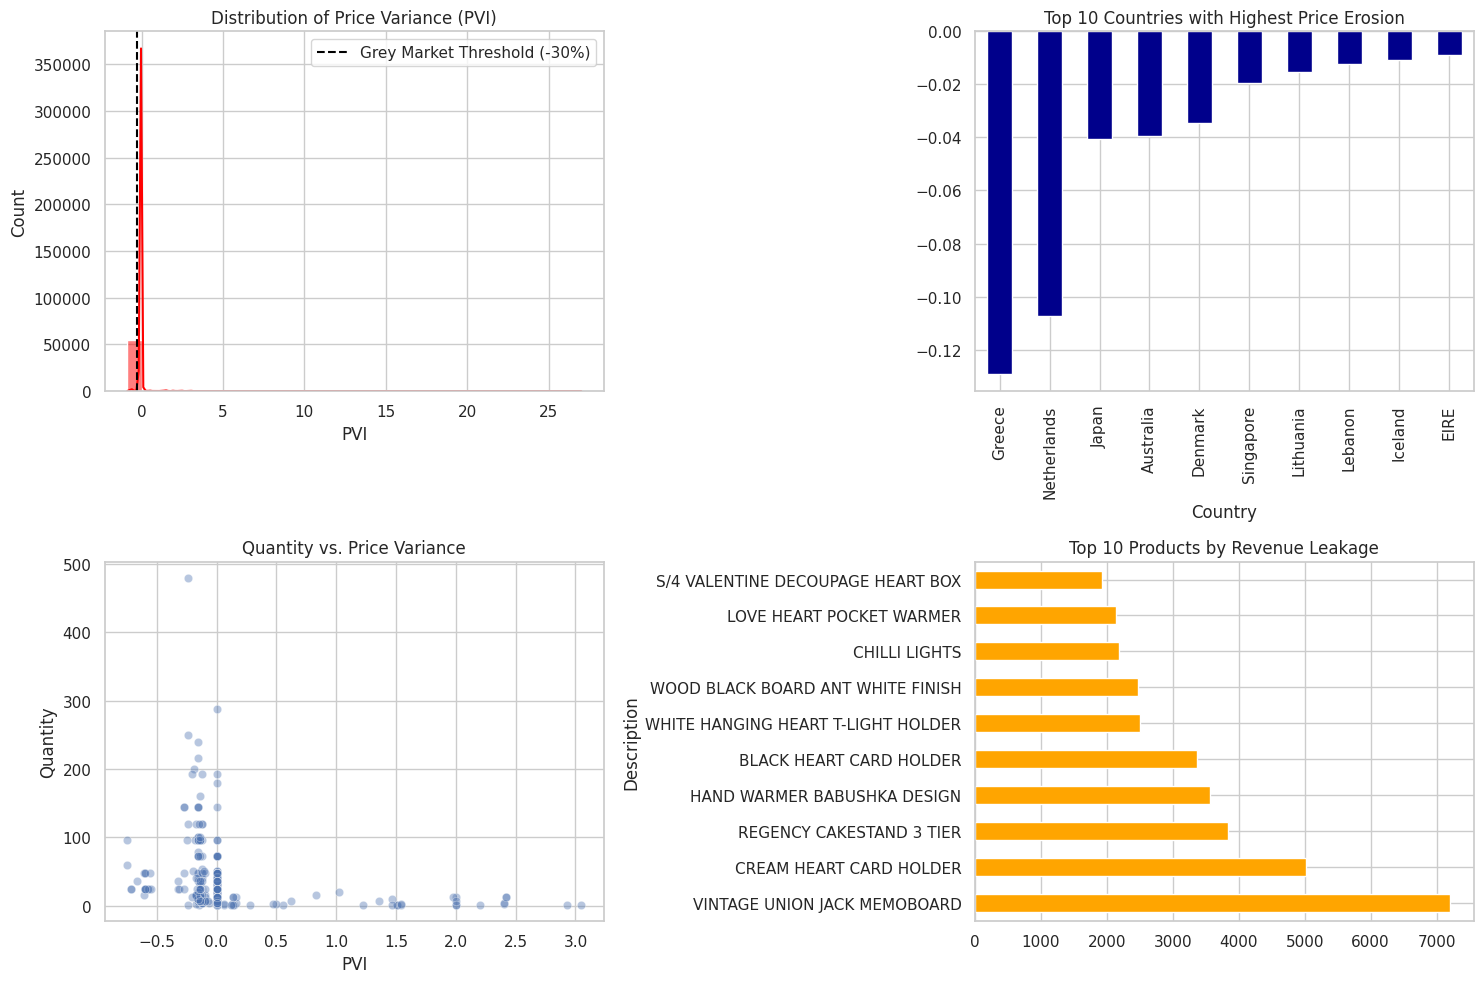

In [5]:
plt.figure(figsize=(15, 10))

# Viz 1: Price Deviation Histogram
plt.subplot(2, 2, 1)
sns.histplot(df_enriched['PVI'], bins=30, kde=True, color='red')
plt.title("Distribution of Price Variance (PVI)")
plt.axvline(x=-0.3, color='black', linestyle='--', label='Grey Market Threshold (-30%)')
plt.legend()

# Viz 2: Geographic Risk (Top 10 Leaky Markets)
plt.subplot(2, 2, 2)
risk_by_country = df_enriched.groupby('Country')['PVI'].mean().sort_values().head(10)
risk_by_country.plot(kind='bar', color='darkblue')
plt.title("Top 10 Countries with Highest Price Erosion")

# Viz 3: Bulk Sale Anomalies
plt.subplot(2, 2, 3)
sns.scatterplot(data=df_enriched.sample(min(2000, len(df_enriched))), x='PVI', y='Quantity', alpha=0.4)
plt.title("Quantity vs. Price Variance")

# Viz 4: Financial Impact
plt.subplot(2, 2, 4)
top_loss_products = df_enriched.groupby('Description')['Revenue_At_Risk'].sum().sort_values(ascending=False).head(10)
top_loss_products.plot(kind='barh', color='orange')
plt.title("Top 10 Products by Revenue Leakage")

plt.tight_layout()
plt.show()

**5. Visualizing the Fraud Landscape (Updated)**

**Description :**

**5.1. Identifying Suspicious Patterns**
We use a multi-dimensional approach to visualize fraud. Beyond simple price checks, we look for Wholesale Leakage (large quantities at low prices) and Geographic Clusters of price erosion.

**The 5 Visualizations include:**

**PVI Distribution:** Identifying the "Deep Discount" anomalies.

**Country Risk Heatmap:** Spotting geographic hubs of unauthorized distribution.

**Volume vs. Price Variance:** Catching unauthorized wholesalers (High volume + High discount).

**Revenue Leakage by Product:** Quantifying the financial damage per SKU.

**Daily Transaction Velocity (New):** Spotting "Flash Dumping"—sudden spikes in transactions for a single product that indicate a grey market entry.

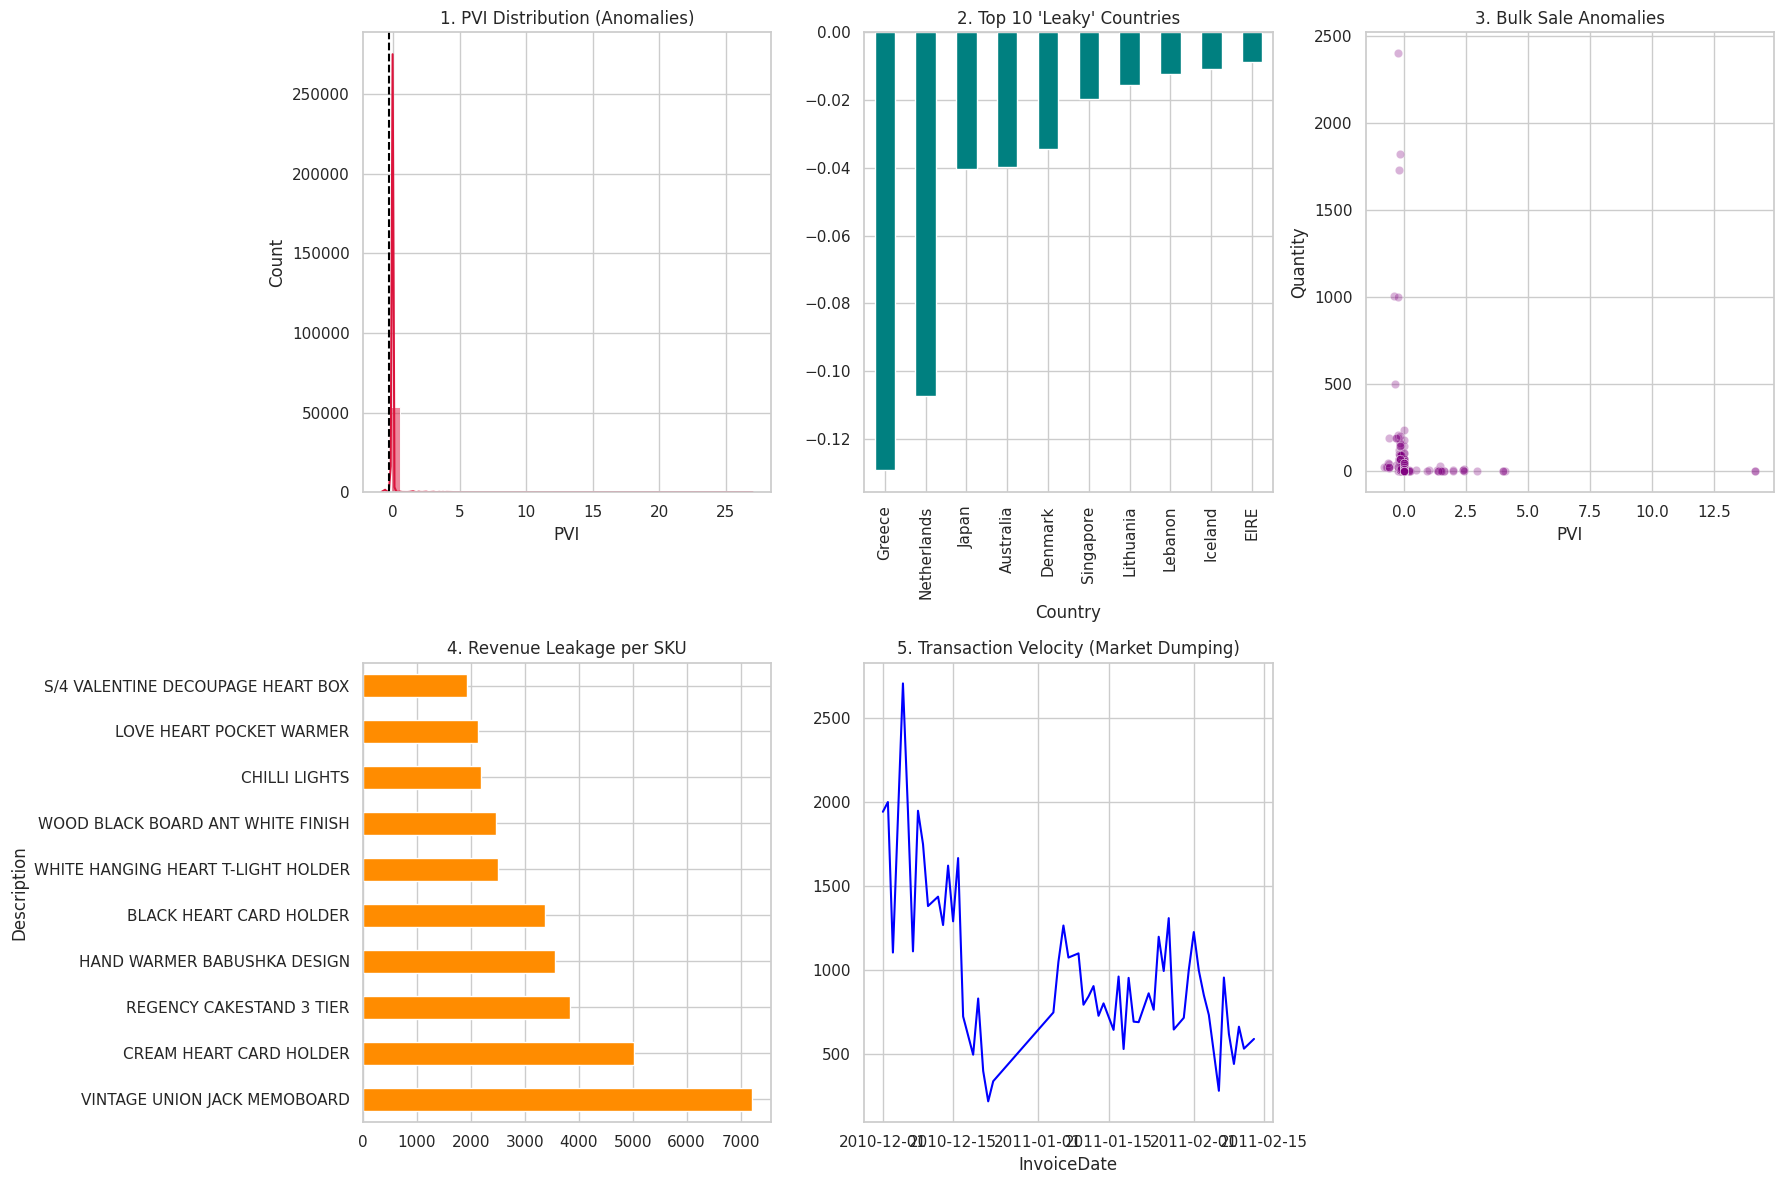

In [6]:
# CODE CELL (Add this to your existing viz code)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 12))

# 1. Distribution of Price Variance Index (PVI)
plt.subplot(2, 3, 1)
sns.histplot(df_enriched['PVI'], bins=40, color='crimson', kde=True)
plt.title("1. PVI Distribution (Anomalies)")
plt.axvline(x=-0.3, color='black', linestyle='--') # Grey Market Threshold

# 2. Geographic Price Erosion (Top 10)
plt.subplot(2, 3, 2)
risk_by_country = df_enriched.groupby('Country')['PVI'].mean().sort_values().head(10)
risk_by_country.plot(kind='bar', color='teal')
plt.title("2. Top 10 'Leaky' Countries")

# 3. Wholesale Leakage (Quantity vs. Discount)
plt.subplot(2, 3, 3)
sns.scatterplot(data=df_enriched.sample(min(2000, len(df_enriched))),
                x='PVI', y='Quantity', alpha=0.3, color='purple')
plt.title("3. Bulk Sale Anomalies")

# 4. Total Financial Impact per SKU
plt.subplot(2, 3, 4)
top_loss = df_enriched.groupby('Description')['Revenue_At_Risk'].sum().sort_values(ascending=False).head(10)
top_loss.plot(kind='barh', color='darkorange')
plt.title("4. Revenue Leakage per SKU")

# 5. NEW: Transaction Velocity (Dumping Pattern)
# We look for days with abnormal transaction counts for specific high-risk products
plt.subplot(2, 3, 5)
df_enriched['InvoiceDate'] = pd.to_datetime(df_enriched['InvoiceDate'])
velocity = df_enriched.groupby(df_enriched['InvoiceDate'].dt.date).size()
velocity.plot(color='blue')
plt.title("5. Transaction Velocity (Market Dumping)")

plt.tight_layout()
plt.show()